# Neural Networks for Handwritten Digit Recognition, Multiclass 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
%matplotlib widget
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

from utils import *

# from public_tests import * 
# from autils import *
# from lab_utils_softmax import plt_softmax
np.set_printoptions(precision=2)

#### Dataset

In [2]:
# load dataset
X, y = load_data()

#### View the variables


In [3]:
print ('The first element of X is: ', X[0])

The first element of X is:  [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  8.56e-06  1.94e-06 -7.37e-04
 -8.13e-03 -1.86e-02 -1.87e-02 -1.88e-02 -1.91e-02 -1.64e-02 -3.78e-03
  3.30e-04  1.28e-05  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.16e-04  1.20e-04 -1.40e-02 -2.85e-02  8.04e-02
  2.67e-01  2.74e-01  2.79e-01  2.74e-01  2.25e-0

In [4]:
print ('The first element of y is: ', y[0,0])
print ('The last element of y is: ', y[-1,0])

The first element of y is:  0
The last element of y is:  9


#### Check the dimensions of your variables

In [5]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))

The shape of X is: (5000, 400)
The shape of y is: (5000, 1)


#### Visualizing the Data

- In the cell below, the code randomly selects 64 rows from `X`, maps each row back to a 20 pixel by 20 pixel grayscale image and displays the images together. 
- The label for each image is displayed above the image 

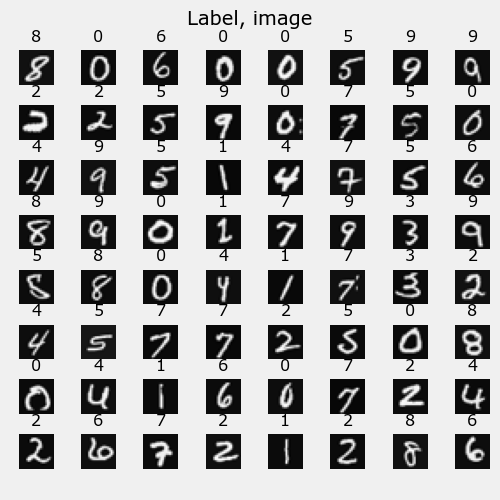

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

#fig.tight_layout(pad=0.5)
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()
    fig.suptitle("Label, image", fontsize=14)

#### Model representation

- This has two dense layers with ReLU activations followed by an output layer with a linear activation. 
    - Our inputs are pixel values of digit images.
    - Since the images are of size $20\times20$, this gives us $400$ inputs  
    
<img src="NN.png" width="600" height="450">

#### Softmax placement
Numerical stability is improved if the softmax is grouped with the loss function rather than the output layer during training. This has implications when *building* the model and *using* the model.  
Building:  
* The final Dense layer should use a 'linear' activation. This is effectively no activation. 
* The `model.compile` statement will indicate this by including `from_logits=True`.
`loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) `  
* This does not impact the form of the target. In the case of SparseCategorialCrossentropy, the target is the expected digit, 0-9.

Using the model:
* The outputs are not probabilities. If output probabilities are desired, apply a softmax function.

#### Tensorflow Model Implementation


In [7]:
#Sequential model
tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [               
        tf.keras.layers.InputLayer((400,)),
        tf.keras.layers.Dense(25, activation="relu", name="L1"),
        tf.keras.layers.Dense(15, activation="relu", name="L2"),
        tf.keras.layers.Dense(10, activation="linear", name="L3")
    ], name = "my_model" 
)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [8]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 25)                10025     
                                                                 
 L2 (Dense)                  (None, 15)                390       
                                                                 
 L3 (Dense)                  (None, 10)                160       
                                                                 
Total params: 10575 (41.31 KB)
Trainable params: 10575 (41.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

In [9]:
[layer1, layer2, layer3] = model.layers

In [10]:
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


In [11]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    X,y,
    epochs=40
)

Epoch 1/40
157/157 [==============================] - 2s 4ms/step - loss: 1.5222
Epoch 2/40
157/157 [==============================] - 1s 4ms/step - loss: 0.6274
Epoch 3/40
157/157 [==============================] - 1s 4ms/step - loss: 0.4558
Epoch 4/40
157/157 [==============================] - 1s 3ms/step - loss: 0.3791
Epoch 5/40
157/157 [==============================] - 0s 2ms/step - loss: 0.3329
Epoch 6/40
157/157 [==============================] - 0s 2ms/step - loss: 0.3017
Epoch 7/40
157/157 [==============================] - 0s 2ms/step - loss: 0.2705
Epoch 8/40
157/157 [==============================] - 0s 2ms/step - loss: 0.2484
Epoch 9/40
157/157 [==============================] - 0s 2ms/step - loss: 0.2343
Epoch 10/40
157/157 [==============================] - 0s 2ms/step - loss: 0.2098
Epoch 11/40
157/157 [==============================] - 0s 2ms/step - loss: 0.1983
Epoch 12/40
157/157 [==============================] - 0s 2ms/step - loss: 0.1869
Epoch 13/40
157/157 [====

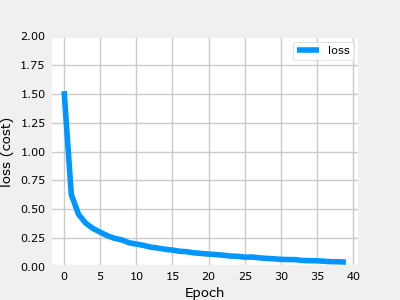

In [12]:
plot_loss_tf(history)

#### Prediction 
To make a prediction, use Keras `predict`. Below, X[1015] contains an image of a two.

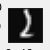

1/1 [==============================] - 0s 230ms/step
 predicting a Two: 
[[ -8.54   5.97  10.62   5.87 -13.87  -8.33  -6.39   5.42   1.22  -1.51]]
 Largest Prediction index: 2


In [13]:
image_of_two = X[1015]
display_digit(image_of_two)

prediction = model.predict(image_of_two.reshape(1,400))  # prediction

print(f" predicting a Two: \n{prediction}")
print(f" Largest Prediction index: {np.argmax(prediction)}")

Let's compare the predictions vs the labels for a random sample of 64 digits.

1/1 [==============================] - 0s 31ms/step


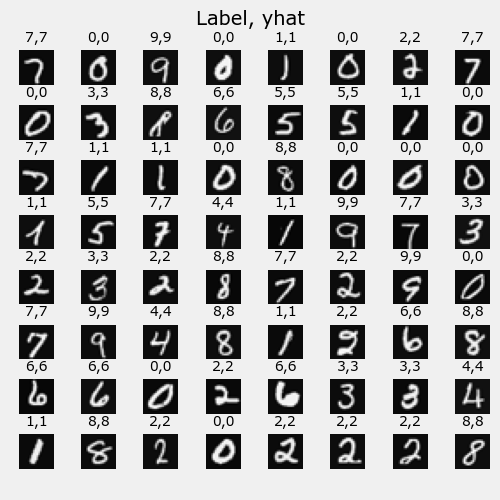

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Predict using the Neural Network
    prediction = model.predict(X[random_index].reshape(1,400))
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)
    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{yhat}",fontsize=10)
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=14)
plt.show()

Let's look at some of the errors. 
>Note: increasing the number of training epochs can eliminate the errors on this data set.

1/1 [==============================] - 0s 30ms/step
35 errors out of 5000 images


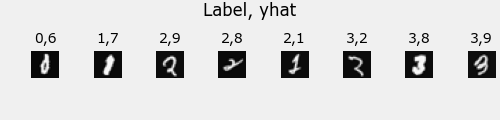

In [15]:
print( f"{display_errors(model,X,y)} errors out of {len(X)} images")